##### Load Wikitext dataset (please run!)

Headings without any text below it (i.g. only table) are excluded.

In [ ]:
%%capture
!pip install datasets
!pip install numpy
!pip install pandas
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [ ]:
import datasets
from datasets import load_dataset, list_datasets
import pandas as pd 
import re 
import numpy as np 

In [ ]:
class Node(object):
    '''
    each node contains 
    - parent 
    - children 
    - text
    '''
    def __init__(self,txt: str, level:int):
        self.text = txt 
        self.level = level
        self.parent = None 
        self.children = []
    def insertChild(self,child):
        self.children.append(child)
    def linkParent(self, parent):
        if(self.parent != None):
            print("ERROR: node ", self.text, "already has a parent")
        else:
            self.parent = parent 
            
        
class Tree(object):
    def __init__(self,document):
        self.root = Node(document['title'],level=0)
        self.depth = np.amax([v['type'] for v in document['document']], initial=0)
        curNode = self.root 
        # para of format {"text", "type"}
        for para in document['document']:
            newNode = Node(para['text'],para['type'])
            
            # growing in depth
            if(newNode.level == -1 or newNode.level > curNode.level):
                curNode.insertChild(newNode)
                newNode.linkParent(curNode)
                if(newNode.level > 0):
                    curNode = newNode 
                
            # new heading belong to the same or lower level of subheading 
            else: 
                # trace back to the heading level that new heading is immediately under 
                while(curNode.level>=newNode.level):
                    curNode = curNode.parent
                curNode.insertChild(newNode)
                newNode.linkParent(curNode)
                curNode = newNode 
        return 
    
    def printTree(self):
        print("======== PRINTING TREE =========")
        print("TITLE: ", self.root.text)
        print("MAX DEPTH: ", self.depth)
        print("===============================")
        def printNode(curNode):
            print(curNode.text)
            if(curNode.level == -1):
                return 
            
            for child in curNode.children:
                printNode(child)
            return 
        printNode(self.root)
        
    

        

In [ ]:
## helper functions 

# get type of text 
def checkHeading(txt):
    if(txt == ''):
        return -2
    if(re.search(r'^\s=.+\s=\s\n',txt)):
        return int(len(re.findall(r'\s=',txt))/2 - 1)
    return -1 

# load documents to feed to tree 
def createDocuments(data):
    documents_with = []
    documents_without = []
    document_with = []
    document_without = []
    curTitle = ''
    for i in data:
        c = checkHeading(i)
        if(c==-2):
            continue
        if(c>-1):
            # strip heading 
            i = re.findall(r'=\s([^=]+)\s=', i)[0]
        if(c==0):
            
            # clear out empty headings 
            while(len(document_with)>1 and document_with[-1]['type']!=-1):
                document_with.pop(-1)
            documents_with.append({'title': curTitle, 'document':document_with})
            documents_without.append(document_without)
            curTitle = i
            document_with = []
            document_without = []
            
        else:
            # clear out empty headings GOOFY HELP HOW TO CLEAN THIS UP 
            if(len(document_with)>1 and document_with[-1]['type']!=-1 and c <= document_with[-1]['type'] and c!=-1):
                document_with.pop(-1)
            document_with.append({'text':i,'type':c})
            if(c==-1):
                document_without.append(i)
            
    documents_with.pop(0)
    documents_without.pop(0)
    return documents_with, documents_without

loadData() creates a list of data points containing the title of article, raw text (paragraphs), and the tree representation of heading structures.

In [ ]:
## load wiki dataset 
def loadData(train = False, min_size=-1):
    """
    prepare dataset for training, which is a list of dictionaries containing:  
    - document title (string)
    - paragraphs (list of string)
    - tree representation of headings
    """
    
    data_raw = load_dataset("wikitext",'wikitext-103-v1',split='train' if train else 'test')
    data_raw = data_raw['text']
    documents_with, documents_without = createDocuments(data_raw)
    
    data = []
    i = 0
    for document in documents_with:
        tree = Tree(document)
        if len(documents_without[i]) < min_size:
          continue
#         tree.printTree()
        data.append({
            "title":document['title'],
            "paragraphs":documents_without[i],
            "tree": tree
        })
        i+=1
    return data    

In [ ]:
data = loadData(train=True)

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.


testing: compared tree pre-order traversal of 10 documents with raw data. No bug. 

##### Training set statistics

Include stats of  
- number of paragraphs per article  
- average length of paragraphs per article 
- maximum depth of articles  

In [ ]:
from matplotlib import pyplot as plt 
import numpy as np
import scipy.stats as stats
def getStat(data):
    # number of paragraphs per article 
    num_para = np.array([len(x['paragraphs']) for x in data])
    counts, edges, bars = plt.hist(num_para,40)
    print("========= number of paragraphs per article========")
    print(pd.Series(num_para).describe())
    plt.show()
    
    # number of sentences per paragraph 
    para_lens = []
    for d in data:
        paras = d['paragraphs']
        for para in paras:
            lgh = len(para.split('.'))-1
            para_lens.append(lgh)
    print("========= number of sentences per paragraph========")
    print(pd.Series(para_lens).describe())
    _,_,_ = plt.hist(para_lens,40)
    plt.show()

    
    # depth of articles 
    depths = [d['tree'].depth for d in data]
    print("========= maximum depth of articles========")
    print(pd.Series(depths).describe())
    _,_,_ = plt.hist(depths)
    plt.show()

    return 
    

========= number of paragraphs per article========
count    29444.000000
mean        29.206052
std         25.829840
min          1.000000
25%         12.000000
50%         21.000000
75%         37.000000
max        284.000000
dtype: float64


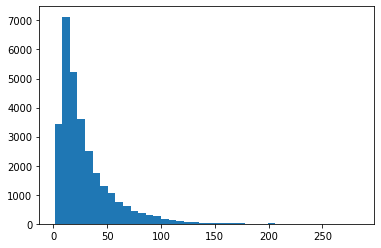

========= number of sentences per paragraph========
count    859943.000000
mean          4.830331
std           3.650685
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          75.000000
dtype: float64


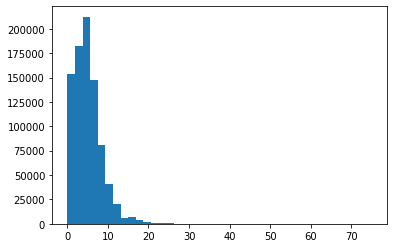

========= maximum depth of articles========
count    29444.000000
mean         1.758355
std          0.686543
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
dtype: float64


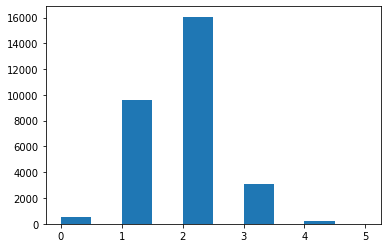

In [ ]:
getStat(data)

##### Preparing SimCSE and Doc2Vec embeddings + related setup (please run!)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import random
random.seed(10)
torch.manual_seed(0)
np.random.seed(0)
import re
import time
import math
from IPython.utils import io

In [ ]:
%%capture
!pip install simcse

In [ ]:
from simcse import SimCSE
simcse_model = SimCSE("princeton-nlp/sup-simcse-bert-base-uncased")

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [ ]:
# # mini-demo with print suppression
# with io.capture_output() as captured:
#     print('this should not be printed')
#     embeddings = simcse_model.encode("A woman is reading, and a man is here")
# print('this should be printed')
# print(embeddings.shape)

In [ ]:
SIMCSE_DIM = 768
MAX_DEPTH = 8
# MAX_PARAS = 300
# MAX_SENTS_PER_PARA = 80

In [ ]:
# for segmentation
START_IDX = 0
END_IDX = MAX_DEPTH

In [ ]:
!pip install gensim==4.1.2
!pip install cython
!pip install nltk

import nltk
nltk.download('punkt')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

     |████████████████████████████████| 24.1 MB 5.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Train Doc2Vec Encoder (only done once, after that we load from 'd2v.model')

In [ ]:
# # DONT NEED TO RUN THIS CELL IF U HAVE THE FILES
# documents = [d['paragraphs'] for d in data]
# paragraphs = []
# for doc in documents:
#   for p in doc:
#     paragraphs.append(p)
# # print(len(paragraphs))
# tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(paragraphs)]


# max_epochs = 15
# vec_size = 128
# alpha = 0.025

# with io.capture_output() as captured:
#     doc2vec_model = Doc2Vec(vector_size=128, min_count=2, window=2, workers=4, dm=1, alpha=alpha, min_alpha=0.00025)
#     doc2vec_model.build_vocab(tagged_data)

# for epoch in range(max_epochs):
#     print('iteration {0}'.format(epoch))
#     with io.capture_output() as captured:
#         doc2vec_model.train(tagged_data,
#                             total_examples=doc2vec_model.corpus_count,
#                             epochs=4)
#     # decrease the learning rate
#     doc2vec_model.alpha -= 0.0002
#     # fix the learning rate, no decay
#     doc2vec_model.min_alpha = doc2vec_model.alpha

# doc2vec_model.save("d2v.model")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make sure to add 484-finalProject as shortcut in drive.

In [ ]:
cd /content/drive/My\ Drive/484-finalProject

/content/drive/.shortcut-targets-by-id/154EdVBqpeIxqbeun-wGvxSgsYCVV1wdV/484-finalProject


In [ ]:
doc2vec_model= Doc2Vec.load("models/128_d2v.model")

05/02/2022 23:09:54 - INFO - gensim.utils -   loading Doc2Vec object from models/128_d2v.model
05/02/2022 23:09:56 - INFO - gensim.utils -   loading dv recursively from models/128_d2v.model.dv.* with mmap=None
05/02/2022 23:09:56 - INFO - gensim.utils -   loading vectors from models/128_d2v.model.dv.vectors.npy with mmap=None
05/02/2022 23:10:04 - INFO - gensim.utils -   loading wv recursively from models/128_d2v.model.wv.* with mmap=None
05/02/2022 23:10:04 - INFO - gensim.utils -   loading vectors from models/128_d2v.model.wv.vectors.npy with mmap=None
05/02/2022 23:10:06 - INFO - gensim.utils -   loading syn1neg from models/128_d2v.model.syn1neg.npy with mmap=None
05/02/2022 23:10:09 - INFO - gensim.utils -   setting ignored attribute cum_table to None
05/02/2022 23:10:11 - INFO - gensim.utils -   Doc2Vec lifecycle event {'fname': 'models/128_d2v.model', 'datetime': '2022-05-02T23:10:11.848870', 'gensim': '4.1.2', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'p

In [ ]:
# # Experiment with inference and lookups :)
# test1 = word_tokenize("This is a test of the paragraph embedding model.".lower())
# test2 = word_tokenize("I am testing my model to encode paragraphs.".lower())
# test3 = word_tokenize("Complete gibberish, baby talk with a model. Goo goo ga ga.")
# test4 = word_tokenize("This is a test for my model to embed paragraphs.".lower())

# v = doc2vec_model.infer_vector(test1)
# v1 = doc2vec_model.infer_vector(test1)
# v2 = doc2vec_model.infer_vector(test2)
# v3 = doc2vec_model.infer_vector(test3)
# v4 = doc2vec_model.infer_vector(test4)
# print(np.linalg.norm(v1 - v))  # normal inference, turns tokenized, lowercase paragraph into 128-vector
# print(np.linalg.norm(v1 - v2)) 
# print(np.linalg.norm(v1 - v3))
# print(np.linalg.norm(v1 - v4))
# print()

# print(np.dot(v1, v)/(np.linalg.norm(v1)*np.linalg.norm(v)))  # normal inference, turns tokenized, lowercase paragraph into 128-vector
# print(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))
# print(np.dot(v1, v3)/(np.linalg.norm(v1)*np.linalg.norm(v3)))
# print(np.dot(v1, v4)/(np.linalg.norm(v1)*np.linalg.norm(v4)))

# print()
# print(doc2vec_model.similarity_unseen_docs(test, test4))

# # print(doc2vec_model.dv['2'])  # dictionary where each paragraph embedding has a numbered id

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##### Preparing LCA loss evaluation function + tools for trees (please run!)

In [ ]:
# tree-related helper functions

# iterate over a tree rooted at node in preorder traversal
def preorder(node):
    if len(node.children) == 0:
        yield node
    for ch in node.children:
        yield from preorder(ch)

# only prints leaves, i.e. text representations of paragraph
# note: depends on accurate text, level population
# text should be indices
def print_tree(curNode):
    if curNode.level == -1:
        print(curNode.text, end='')
        return
    print('[', end='')
    for idx, child in enumerate(curNode.children):
        print_tree(child)
        if idx < len(curNode.children) - 1:
            print(', ', end='')
    print(']', end='')
    if curNode.level == 0:
        print() # final print after entire tree is printed

# text should be snippets
def print_snippet_tree(curNode, indent='  '):
    if curNode.level == -1:
        print(indent + curNode.text, end='')
        return
    print(indent+'[heading]')
    for idx, child in enumerate(curNode.children):
        print_snippet_tree(child, indent+'  ')
        if idx < len(curNode.children) - 1:
            print()
    if curNode.level == 0:
        print() # final print after entire tree is printed

def clone_tree(root):
    root_copy = Node(root.text, root.level)
    for ch in root.children:
        root_copy.insertChild(clone_tree(ch))
        root_copy.children[-1].linkParent(root_copy)
    return root_copy

# return indexified tree with text as paragraphs to text as indices of paragraphs for more concise printing
def indexified_tree(root):
    root_copy = clone_tree(root)
    for idx, node in enumerate(preorder(root_copy)):
        node.text = idx
    return root_copy

# return indexified tree with text as paragraphs to text as indices of paragraphs for more concise printing
def textified_tree(root, paras):
    root_copy = clone_tree(root)
    for idx, node in enumerate(preorder(root_copy)):
        node.text = paras[idx][:40] + '...'
    return root_copy

# print_tree(roots[0])
# print_tree(train_y[0].root)

In [ ]:
# lca-related helper functions and lca loss
# note: assumed indexified trees
def trace_helper(node, i, trace):
    if node.text == i:
        return True
    for idx, ch in enumerate(node.children):
        if trace_helper(ch, i, trace):
            trace.append(idx)
            return True
    return False

def get_trace(root, i):
    trace = []
    trace_helper(root, i, trace)
    trace.reverse()
    return trace

def compute_lca_dist(root, i, j):
    trace_i = get_trace(root, i)
    trace_j = get_trace(root, j)
    # print(trace_i)
    # print(trace_j)
    for idx in range(min(len(trace_i), len(trace_j))):
        if trace_i[idx] != trace_j[idx]:
            return len(trace_i) + len(trace_j) - 2 * idx
    return len(trace_i) + len(trace_j)

def lca_loss(root1, root2, num_paras):
    loss = 0
    for i in range(2, num_paras+1): # 1-indexed from indexify
        j = i-1
        dist1 = compute_lca_dist(root1, i, j)
        dist2 = compute_lca_dist(root2, i, j)
        # print(i, j, dist1, dist2)
        loss += (dist1 - dist2) * (dist1 - dist2)
    if num_paras == 1:
        return loss
    return loss / (num_paras - 1)

# def lca_loss(root1, root2, num_paras):
#     loss = 0
#     for i in range(1, num_paras+1): # 1-indexed from indexify
#         for j in range(i+1, num_paras+1):
#             dist1 = compute_lca_dist(root1, i, j)
#             dist2 = compute_lca_dist(root2, i, j)
#             # print(i, j, dist1, dist2)
#             loss += (dist1 - dist2) * (dist1 - dist2)
#     if num_paras == 1:
#         return loss
#     return loss / num_paras / (num_paras - 1) * 2

def batch_lca_loss(roots1, roots2, num_paras):
    tt = 0
    for root1, root2, num in zip(roots1, roots2, num_paras):
        tt += lca_loss(root1, root2, num)
    return tt / len(roots1)

##### Model 1: End-to-end -- note this code may be behind the local version on Evan's big boi computer

Approach: SimCSE/Doc2Vec + bidirectional LSTM + transformer -> segmentations

In [ ]:
class HeaderNet(nn.Module):
    def __init__(self, hid_dim=32, n_layers=1, num_heads=4, # CURRENTLY ONLY SUPPROTS N_LAYERS=1
                 num_enc_layers=1, num_dec_layers=1, ff_dim=1024, dropout=0.1, output_dim=2*MAX_DEPTH):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.num_heads = num_heads
        self.num_enc_layers = num_enc_layers
        self.num_dec_layers = num_dec_layers
        self.ff_dim = ff_dim
        self.dropout = dropout

        self.lstm = nn.LSTM(SIMCSE_DIM,
                            hid_dim,
                            num_layers=n_layers,
                            bidirectional=True,
                            batch_first=True)
        self.transformer = nn.Transformer(d_model=hid_dim*4, nhead=num_heads, num_encoder_layers=num_enc_layers,
                                          num_decoder_layers=num_dec_layers, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hid_dim*4, output_dim)

    # masks for transformer to account for variable numbers of paragraphs per article
    def compute_len_masks(self, batch):
        lens = [len(text) for text in batch]
        max_num_paras = max(lens)
        len_masks = torch.zeros(len(batch), max_num_paras)
        for idx, text_len in enumerate(lens):
            len_masks[idx, text_len:] = 1
        return lens, len_masks.to(self.device)

    # compute sentence embeddings from paragraphs in text
    def compute_sentence_embeddings(self, batch):
        num_para = [len(x) for x in batch]
        batch_para = []

        # build list of lists of sentence embeddings
        # note that num paragraphs and num sentences are both variable
        sents_emb = []
        for text in batch:
            for para in text:
                para = re.sub('\n', '', para)
                sents = re.split('[.]|[!]|[?]', para.strip())
                with io.capture_output() as captured:
                    sents_emb_i = simcse_model.encode(sents, device=self.device, batch_size=len(sents))
                sents_emb.append(sents_emb_i)
        return sents_emb

    # returns a list of slices along the first dim according to a given list of slice lengths
    def partition(self, data, lens):
        data_list = []
        idx = 0
        for len_i in lens:
            data_list.append(data[idx:idx+len_i])
            idx += len_i
        return data_list

    def forward(self, batch):
        # compute len masks
        lens, len_masks = self.compute_len_masks(batch)

        # # paragraphs -> sentence embeddings
        # sents_emb = self.compute_sentence_embeddings(batch)
        # sent_lens = [x.shape[0] for x in sents_emb]
        # sents_emb = torch.nn.utils.rnn.pad_sequence(sents_emb, batch_first=True).to(device)
        # packed_in = torch.nn.utils.rnn.pack_padded_sequence(sents_emb, sent_lens, batch_first=True, enforce_sorted=False)

        # # sentence embeddings -> paragraph embeddings
        # packed_out, (hidden, cell) = self.lstm(packed_in.to(self.device))
        # para_emb = torch.cat((hidden[0], cell[0], hidden[1], cell[1]), dim=1)
        # para_list = self.partition(para_emb, lens) # group paragraph embeddings by article
        # print(len(para_list))
        # print(para_list[0].shape)
        # text_emb = torch.nn.utils.rnn.pad_sequence(para_list, batch_first=True).to(device)
        
        
        para_list = []
        for article in batch:
          para_list.append(torch.stack([torch.tensor(doc2vec_model.infer_vector(word_tokenize(p.lower())), device=device) for p in article], dim=0))
        text_emb = torch.nn.utils.rnn.pad_sequence(para_list, batch_first=True).to(device)
        
        # paragraph embeddings -> outlines
        logits = self.transformer(text_emb, text_emb, src_key_padding_mask=len_masks, tgt_key_padding_mask=len_masks)
        logits = logits[len_masks == 0]
        logits = self.linear(logits)
        logit_list = self.partition(logits, lens)
        
        return logit_list

    @property
    def device(self) -> torch.device:
        """ Determine which device to place the Tensors upon, CPU or GPU.
        """
        return device
    
    @staticmethod
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        """
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = HeaderNet(**args)
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, path: str):
        """ Save the model to a file.
        @param path (str): path to the model
        """

        params = {
            'args': dict(hid_dim=self.hid_dim, n_layers=self.n_layers, num_heads=self.num_heads,
                 num_enc_layers=self.num_enc_layers, num_dec_layers=self.num_dec_layers, ff_dim=self.ff_dim, dropout=self.dropout),
            'state_dict': self.state_dict()
        }

        torch.save(params, path)

In [ ]:
# # encode just the depths -- note that this is insufficient to reconstruct the tree
# def add_tree_depths(node, depths, cur_depth):
#     if node.level == -1: # this is paragraph node, not a heading
#         depths.append(cur_depth)
#         return
#     for child in node.children:
#         add_tree_depths(child, depths, cur_depth+1)

# def get_depths(trees, one_hot=True):
#     depths = []
#     for tree in trees:
#         depths_i = []
#         add_tree_depths(tree.root, depths_i, 0)
#         if one_hot:
#             depths.append(F.one_hot(torch.tensor(depths_i), num_classes=MAX_DEPTH))
#         else:
#             depths.append(torch.tensor(depths_i))
#     return torch.stack(depths, dim=0)

# encode outlines
# note: we use 0 as padding symbol
def add_tree_outlines(node, outlines, cur_outline):
    if node.level == -1: # this is paragraph node, not a heading
        outlines.append(torch.clone(cur_outline))
        return
    for child in node.children:
        cur_outline[node.level] += 1
        add_tree_outlines(child, outlines, cur_outline)
    cur_outline[node.level] = 0

def get_outlines(paras, trees):
    max_paras = max([len(x) for x in paras])
    outlines = []
    for tree in trees:
        outlines_i = []
        add_tree_outlines(tree.root, outlines_i, torch.zeros(MAX_DEPTH))
        outlines_i = torch.stack(outlines_i, dim=0).to(device)
        outlines.append(outlines_i)
    return outlines

# encode breaks

def add_tree_segs(node, outlines, cur_outline):
    if node.level == -1: # this is paragraph node, not a heading
        outlines.append(torch.clone(cur_outline))
        return
    for child in node.children:
        if child == node.children[0]: # first entry
            cur_outline[START_IDX + node.level] = 1
        if child == node.children[-1]:
            cur_outline[END_IDX + node.level] = 1
        add_tree_segs(child, outlines, cur_outline)
        if child == node.children[0]:
            cur_outline[START_IDX + node.level] = 0
        if child == node.children[-1]:
            cur_outline[END_IDX + node.level] = 0
    cur_outline[node.level+1] = 0

def get_segs(paras, trees):
    max_paras = max([len(x) for x in paras])
    outlines = []
    for tree in trees:
        outlines_i = []
        add_tree_segs(tree.root, outlines_i, torch.zeros(2*MAX_DEPTH))
        outlines_i = torch.stack(outlines_i, dim=0).to(device)
        outlines.append(outlines_i)
    return outlines

In [ ]:
# test demo
# model = HeaderNet()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print('use device: %s' % device)
# model = model.to(device)
# y_hat = model(train_X[0:5])
# y = get_outlines(train_X[0:5], train_y[0:5])

In [ ]:
def get_paragraphs_trees(data):
    paras = [d['paragraphs'] for d in data]
    trees = [d['tree'] for d in data]
    return paras, trees

def get_split_data(data, train_ratio=0.05, val_ratio=0.001, test_ratio=0.002):
    random.shuffle(data)
    n_data = len(data)
    train_idx = int(train_ratio*n_data)
    val_idx = int((train_ratio + val_ratio)*n_data)
    test_idx = int((train_ratio + val_ratio + test_ratio)*n_data)
    train_X, train_y = get_paragraphs_trees(data[:train_idx])
    val_X, val_y = get_paragraphs_trees(data[train_idx:val_idx])
    test_X, test_y = get_paragraphs_trees(data[val_idx:test_idx])
    return train_X, train_y, val_X, val_y, test_X, test_y

In [ ]:
train_X, train_y, val_X, val_y, test_X, test_y = get_split_data(data)

In [ ]:
train_reshaped = torch.cat(get_segs(train_X, train_y), dim=0)
train_mean = torch.mean(train_reshaped, dim=0)
train_std = torch.std(train_reshaped, dim=0)
train_std += 1e-6 # deal with div by zero
def normalize(segs):
    normed_segs = []
    for s in segs:
        normed_segs.append(torch.div(torch.sub(s, train_mean), train_std))
    return normed_segs

In [ ]:
# # testing normalize
# segs = get_segs(train_X, train_y)
# normed_segs = normalize(get_segs(train_X, train_y))

# v_segs = get_segs(val_X, val_y)
# v_normed_segs = normalize(get_segs(val_X, val_y))

# print(torch.mean(torch.cat(segs),dim=0))
# print(torch.mean(torch.cat(normed_segs),dim=0))
# print(torch.std(torch.cat(segs),dim=0))
# print(torch.std(torch.cat(normed_segs),dim=0))

# print(torch.mean(torch.cat(v_segs),dim=0))
# print(torch.mean(torch.cat(v_normed_segs),dim=0))
# print(torch.std(torch.cat(v_segs),dim=0))
# print(torch.std(torch.cat(v_normed_segs),dim=0))

In [ ]:
# iterate over batches of data and labels
# articles in batch are sorted by descending num paragraphs for efficient packing/LSTM inference
def batch_iter(data, labels, batch_size, shuffle=False):
    batch_num = math.ceil(len(data) / batch_size)
    index_array = list(range(len(data)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]
        indices = sorted(indices, key=lambda idx: len(data[idx]), reverse=True)
        batch_data = [data[idx] for idx in indices]
        batch_labels = [labels[idx] for idx in indices]

        yield batch_data, batch_labels

In [ ]:
def outline_loss(y_hat, y, output_format='segmentation'):
    tt_loss = torch.tensor([0.0]).to(device)
    if output_format == 'segmentation':
        weights = [128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1]
    elif output_format == 'outlines':
        weights = [128, 64, 32, 16, 8, 4, 2, 1]
    for y_hat_i, y_i in zip(y_hat, y):
        loss_weights = torch.tensor(weights).to(device).repeat(y_i.shape[0], 1) # exponentially weight higher level headings more
        tt_loss += (torch.square(y_hat_i - y_i)).mul(loss_weights).mean()
    return tt_loss / len(y)

In [ ]:
def train(train_X, train_y, val_X, val_y, lr=0.002, batch_size=32, grad_clip=5.0, lr_decay=0.5,
          max_epoch=50, log_every=5, valid_niter=75, max_patience=4, max_num_trial=5, model_path='model.bin'):
    model = HeaderNet()
    model.train()

    # # initialize model parameters
    # for p in model.parameters():
    #     p.data.uniform_(-0.1, 0.1)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('use device: %s' % device)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print('{} parameters!'.format(sum([np.prod(p.size()) for p in model_parameters])))

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr)

    num_trial = 0
    train_iter = patience = cum_loss = report_loss = cum_tgt_words = report_tgt_words = 0
    cum_examples = report_examples = epoch = valid_num = 0
    hist_valid_scores = []
    train_time = begin_time = time.time()
    print('begin Maximum Likelihood training')

    train_losses = []
    val_losses = []

    while True:
        epoch += 1
        batch_num = math.ceil(len(train_X) / batch_size)
        current_iter = 0
        for examples, labels in batch_iter(train_X, train_y, batch_size=batch_size, shuffle=True):
            model.train()
            current_iter += 1
            train_iter += 1

            optimizer.zero_grad()
            batch_size = len(examples)
            train_loss = outline_loss(model(examples), get_segs(examples, labels))
            train_loss.backward()

            # clip gradient
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            report_loss += train_loss
            cum_loss += train_loss
            report_examples += batch_size
            cum_examples += batch_size

            if train_iter % log_every == 0:
                print('epoch %d (%d / %d), iter %d, avg train loss %.2f, '
                      'cum examples %d, time elapsed %.2f sec' %
                      (epoch, current_iter, batch_num, train_iter,
                       report_loss / report_examples,
                       cum_examples,
                       time.time() - begin_time))

                train_time = time.time()
                report_loss = report_examples = 0.

            # perform validation
            if train_iter % valid_niter == 0:
                model.eval()
                with torch.no_grad():
                    print('epoch %d, iter %d, cum loss %.2f, cum examples %d' % (epoch, train_iter,
                            cum_loss / cum_examples,
                            cum_examples))
                    train_losses.append(cum_loss / cum_examples)
                    cum_loss = cum_examples = 0.

                    print('begin validation ...')

                    val_cum_loss = 0
                    val_cum_examples = 0

                    count = 0
                    NUM_BATCHES = 16  # number of batches to validate over each time
                    for e, l in batch_iter(val_X, val_y, batch_size, shuffle=True):
                        if count >= NUM_BATCHES:
                            break
                        batch_size = len(e)
                        val_loss = outline_loss(model(e), get_segs(e, l))
                        val_cum_loss += val_loss
                        val_cum_examples += batch_size
                        count += 1

                    val_losses.append(val_cum_loss / val_cum_examples)
                    valid_metric = -val_cum_loss / val_cum_examples # metric for evaluating whether model is improving on val data

                    print('validation: iter %d, val loss %f' % (train_iter, val_loss))

                    is_better = len(hist_valid_scores) == 0 or valid_metric > max(hist_valid_scores)
                    hist_valid_scores.append(valid_metric)

                    if is_better:
                        patience = 0
                        print('epoch %d, iter %d: save currently the best model to [%s]' %
                                (epoch, train_iter, model_path))
                        model.save(model_path)
                        torch.save(optimizer.state_dict(), model_path + '.optim')
                        np.save('train.npy', np.array(train_losses))
                        np.save('val.npy', np.array(val_losses))
                    elif patience < max_patience:
                        patience += 1
                        print('hit patience %d' % patience)

                        if patience == max_patience:
                            num_trial += 1
                            print('hit #%d trial' % num_trial)
                            if num_trial == max_num_trial:
                                print('early stop!')
                                exit(0)

                            # decay lr, and restore from previously best checkpoint
                            lr = optimizer.param_groups[0]['lr'] * lr_decay
                            print('load previously best model and decay learning rate to %f' % lr)

                            # load model
                            params = torch.load(model_path, map_location=lambda storage, loc: storage)
                            model.load_state_dict(params['state_dict'])
                            model = model.to(device)
                            train_losses = list(np.load('train.npy'))
                            val_losses = list(np.load('val.npy'))

                            print('restore parameters of the optimizers')
                            optimizer.load_state_dict(torch.load(model_path + '.optim'))

                            # set new lr
                            for param_group in optimizer.param_groups:
                                param_group['lr'] = lr

                            # reset patience
                            patience = 0

        if epoch == max_epoch:
            print('reached maximum number of epochs!')
            break

In [ ]:
train(train_X, train_y, val_X, val_y)

use device: cuda:0
begin Maximum Likelihood training


RuntimeError: ignored

In [ ]:
# print(data[0]['tree'].depth)
# print(data[0]['title'])
# get_outlines([data[0]['paragraphs']], [data[0]['tree']])

##### Model 2: Greedy decoding + LCA loss

In [ ]:
class GreedyDecoder:
    def __init__(self, thresholds, similarity, encode):
        self.thresholds = thresholds
        self.similarity = similarity
        self.encode = encode
    
    # add level and parent info to a tree rooted at node
    def update_levels_parents(self, node, depth):
        # print(node.text)
        if len(node.children) == 0: # leaf paragraph node
            node.level = -1
            return
        node.level = depth
        for ch in node.children:
            ch.linkParent(node)
            self.update_levels_parents(ch, depth+1)

    # decodes and returns tree rooted at node
    def encode_decode(self, paragraphs):
        embs = []
        for para in paragraphs:
            embs.append(self.encode(para))
        return self.decode(embs)
    
    # decodes and returns tree rooted at node, with text fields populated, e.g. for printing the tree
    def encode_decode_with_text(self, X, indexify=True):
        root = self.encode_decode(X)
        for idx, leaf in enumerate(preorder(root)):
            if indexify:
                leaf.text = idx
            else:
                leaf.text = X[idx]
        return root
    
    # here X and y are lists
    def batch_encode_decode_with_text(self, X):
        roots = []
        for X_i in X:
            roots.append(self.encode_decode_with_text(X_i))
        return roots

    # bottom up decoding: for each depth, join paragraphs whose pairwise similarity reaches the threshold
    # and represent them collectively by the mean of their embeddings
    def decode(self, embs):
        if len(embs) == 0:
            return Node('', 0) # should never happen
        roots = []
        for i in range(len(embs)):
            roots.append(Node(i, -1))
        dim = embs[0].shape[0]
        for depth in range(MAX_DEPTH-1): # in last layer, everything must be joined together
            next_idxs = [[0]]
            for i in range(1, len(embs)):
                if self.similarity(embs[i-1], embs[i]) >= self.thresholds[depth]:
                    next_idxs[-1].append(i)
                else:
                    next_idxs.append([i])

            # print(next_idxs)
            # for root in roots:
            #     print_tree(root)

            # update roots and embs
            next_roots = []
            next_embs = []
            for comp in next_idxs:
                # don't add trivial (1 -> 1) edges
                if len(comp) == 1:
                    next_roots.append(roots[comp[0]])
                    next_embs.append(embs[comp[0]])
                    continue

                next_roots.append(Node('', -2)) # meaningless params since we only need tree structure
                next_embs.append(torch.zeros(dim))
                for idx in comp:
                    next_roots[-1].insertChild(roots[idx])
                    next_embs[-1] += embs[idx]
                next_embs[-1] /= len(comp)
            roots = next_roots
            embs = next_embs
        
        # join everything together in the last layer
        root = Node('', 0)
        for node in roots:
            root.insertChild(node)

        # update parents and levels, then return
        self.update_levels_parents(root, 0)
        return root

In [ ]:
# y = indexified_tree(train_y[0].root)
# print_tree(y)
# compute_lca_dist(y, 2, 21)
# compute_lca_dist(y, y_hat, len(train_X[0]))

# greedy = GreedyDecoder([2,3,2,5,5,5,10,10], similarity=doc2vec_sim, encode=doc2vec_enc)
# roots = greedy.batch_encode_decode_with_text([train_X[0]], [train_y[0]])

In [ ]:
def doc2vec_sim(v1, v2):
    return torch.dot(v1, v2) / torch.norm(torch.sub(v1, v2))
def doc2vec_enc(v):
    return torch.tensor(doc2vec_model.infer_vector(word_tokenize(v)))

def simcse_enc(v):
    para = re.sub('\n', '', v)
    sents = re.split('[.]|[!]|[?]', para.strip())
    with io.capture_output() as captured:
        vecs = simcse_model.encode(sents, device=device, batch_size=len(sents))
    return torch.mean(vecs, dim=0)

In [ ]:
def evaluate_thresholds(X, y, thresholds, similarity=doc2vec_sim, encode=doc2vec_enc):
    greedy = GreedyDecoder(thresholds, similarity=similarity, encode=encode)
    y_hat = greedy.batch_encode_decode_with_text(X)
    y = [indexified_tree(y_i.root) for y_i in y]
    lens = [len(x) for x in X]
    return batch_lca_loss(y, y_hat, lens)
    # print('Actual:')
    # print_tree(y_hat[0])
    # print('Predicted:')
    # print_tree(y[0])

def random_search(X, y, n_tries=50, min_num=[0]*8, max_num=[3]*8, similarity=doc2vec_sim, encode=doc2vec_enc):
    results = []
    for i in range(n_tries):
        print('try #' + str(i))
        thresholds = []
        for j in range(8):
            thresholds.append(random.uniform(min_num[j],max_num[j]))
        # print('thresholds:', thresholds)
        loss = evaluate_thresholds(X, y, thresholds, similarity=similarity, encode=encode)
        results.append({'loss':loss, 'thresholds':thresholds})
    
    # print sorted version by each index
    print('printing sorted by component...')
    for i in range(8):
        print('component', i)
        results_sorted = sorted(results, key=lambda x: x['thresholds'][i])
        for result in results_sorted:
            thresh =  ["{0:0.5f}".format(i) for i in result['thresholds']]
            print(result['loss'], '\t', thresh)
        print()

In [ ]:
random_search(train_X[20:40], train_y[20:40], n_tries=10, encode=doc2vec_enc, min_num=[0,0,0,0,0,0,0,0], max_num=[3,3,3,3,3,3,3,3])

NameError: ignored

In [ ]:
def add_tree_breaks(node, breaks, cur_breaks, depths, depth):
    if node.level == -1: # this is paragraph node, not a heading
        depths.append(depth)
        breaks.append(cur_breaks)
        return
    for child in node.children:
        if child == node.children[0]: # first entry
            cur_breaks += 1
            depth = node.level
        if child == node.children[-1]:
            cur_breaks = 0
            depth = 0
        add_tree_breaks(child, breaks, cur_breaks, depths, depth)
        if child == node.children[0]:
            cur_breaks = 0
            depth = 0
        if child == node.children[-1]:
            cur_breaks = 0
            depth = 0
    cur_breaks = 0

def get_breaks(paras, trees):
    max_paras = max([len(x) for x in paras])
    breaks = []
    depths = []
    for tree in trees:
        breaks_i = []
        depths_i = []
        add_tree_breaks(tree.root, breaks_i, 0, depths_i, 0)
        breaks_i = torch.tensor(breaks_i)
        depths_i[0] += 1
        depths_i = torch.tensor(depths_i)
        breaks.append(breaks_i)
        depths.append(depths_i)
    return breaks, depths

def convert_dataset(dataset, window_size):
  breaks, depths = get_breaks([d['paragraphs'] for d in dataset], [d['tree'] for d in dataset])
  X = []
  D = []
  y = []
  for i in tqdm(range(len(dataset))):  # for article
      # print('{}'.format(100 * i / len(dataset)))
      article = dataset[i]['paragraphs']
      for p in range(1, len(article)):  # for para in article (excluding first, since its clearly always a break)
          depth = depths[i][p]
          isBreak = breaks[i][p]
          for b in range(1, depth + 1):  # for depths <= depth of para
              context = []
              for j in range(p - window_size, p + window_size + 1):  # for para in context
                  if j < 0 or j >= len(article):
                      context.append(None)
                  else:
                      context.append(article[j])
              X.append(context)
              D.append(np.array([b]))
              val = 1 if b > depth - isBreak else 0  # 1 if target para is first after break at depth b
              y.append(np.array([val]))
          if depth == 0:
              for b in range(1, 8):  # MAX_DEPTH is 8
                  context = []
                  for j in range(p - window_size, p + window_size + 1):  # for para in context
                      if j < 0 or j >= len(article):
                        context.append(None)
                      else:
                        context.append(article[j])
                  X.append(context)
                  D.append(np.array([0]))
                  y.append(np.array([0]))
  return X, torch.tensor(np.stack(D, axis=0)), torch.tensor(np.stack(y, axis=0))

def get_split_data(data, window_size, train_ratio=0.8, val_ratio=0.0001, test_ratio=0.0001):
    random.shuffle(data)
    n_data = len(data)
    train_idx = int(train_ratio * n_data)
    val_idx = int((train_ratio + val_ratio) * n_data)
    test_idx = int((train_ratio + val_ratio + test_ratio) * n_data)
    print('getting training data')
    train_data = convert_dataset(data[:train_idx], window_size=window_size)
    print('getting val data')
    val_data = convert_dataset(data[train_idx:val_idx], window_size=window_size)
    print('getting test data')
    test_data = convert_dataset(data[val_idx:test_idx], window_size=window_size)
    return train_data, val_data, test_data

# iterate over batches of data and labels
def batch_iter(data, batch_size, shuffle=False):
    X, D, y = data
    batch_num = math.ceil(len(X) / batch_size)
    index_array = list(range(len(X)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]
        batch_data_X = [X[idx] for idx in indices]
        batch_data_D = D[indices]
        batch_data_y = y[indices]

        yield batch_data_X, batch_data_D, batch_data_y

# MODULES FOR EMBEDDING 3 DIFFERENT WAYS: DOC2VEC, PROJECTED SIMCSE, PROJECTED FASTTEXT
# each one takes a batch of lists of paragraphs, outputs a batch of concatenated paragraph embeddings
# forward pass input: batch (len B) of list of paragraphs (len 2 * window_size + 1), each para variable length
# forward pass output: tensor of size B x ((2 * window_size + 1) * emb_dim)
class Doc2VecEmbedding(nn.Module):
  def __init__(self, window_size, emb_dim): 
    super().__init__()
    self.emb_dim = emb_dim
    self.doc2vec = Doc2Vec.load("models/{}_d2v.model".format(emb_dim))

  def forward(self, x):
    with torch.no_grad():
      batch = []
      for b in x:
        paras = []
        for p in b:
          paras.append(self.doc2vec.infer_vector(word_tokenize(p.lower())) if p is not None else np.zeros(shape=(self.emb_dim)))
        batch.append(np.concatenate(paras, axis=0))
      return torch.tensor(np.stack(batch, axis=0)).to(device)

class SimCSEEmbedding(nn.Module):
  def __init__(self, window_size, emb_dim, dropout): 
    super().__init__()
    self.window_size = window_size
    self.emb_dim = emb_dim
    self.simcse = SimCSE("princeton-nlp/sup-simcse-bert-base-uncased")
    self.SIMCSE_DIM = 768 # dim of simcse sentence embeddings
    self.lstm = nn.LSTM(input_size=self.SIMCSE_DIM,
                        hidden_size=int(emb_dim / 4),
                        num_layers=1,
                        bidirectional=True,
                        batch_first=True, 
                        dropout=0.0).to(device)

  def forward(self, x):
    B = len(x)  # batch size
    batch = []
    with torch.no_grad():
      for b in x:
        for p in b:
          if p is not None:
            p = re.sub('\n', '', p)
            sents = re.split('[.]|[!]|[?]', p.strip())
            with io.capture_output() as captured:
                sents_emb = self.simcse.encode(sents, device=device, batch_size=len(sents), max_length=128)  # a tensor of len(sents) x SIMCSE_DIM
            batch.append(sents_emb)
          else:
            batch.append(torch.zeros((1, self.SIMCSE_DIM), device=device))
      batch_emb = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True).to(device)
      packed_in = torch.nn.utils.rnn.pack_padded_sequence(batch_emb, torch.tensor([a.shape[0] for a in batch_emb]), batch_first=True, enforce_sorted=False)

    _, (hidden, cell) = self.lstm(packed_in.to(device))
    para_embs = torch.cat((hidden[0], cell[0], hidden[1], cell[1]), dim=1)        
      
    return para_embs.reshape(B, (2 * self.window_size + 1) * self.emb_dim)


#### HERE
class FastTextEmbedding(nn.Module):
  def __init__(self, window_size, emb_dim, dropout): 
    super().__init__()
    self.window_size = window_size
    self.emb_dim = emb_dim
    self.fasttext = FastText.load_fasttext_format('models/fast-text-300.bin')
    self.FASTTEXT_DIM = 300 # dim of fasttext word embeddings
    self.lstm = nn.LSTM(input_size=self.FASTTEXT_DIM,
                        hidden_size=int(emb_dim / 4),
                        num_layers=1,
                        bidirectional=True,
                        batch_first=True, 
                        dropout=0.0).to(device)

  def forward(self, x):
    B = len(x)  # batch size
    batch = []
    with torch.no_grad():
      for b in x:
        for p in b:
          if p is not None:
            p = re.sub('\n', '', p)
            words = re.sub("[^\s\w]", "", p.strip()).split(' ')
            words = list(filter(None, words))
            words_emb = torch.stack([torch.tensor(self.fasttext[word]) for word in words]).to(device)  # a tensor of len(words) x FASTTEXT_DIM
            batch.append(words_emb)
          else:
            batch.append(torch.zeros((1, self.FASTTEXT_DIM), device=device))
      batch_emb = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True).to(device)
      packed_in = torch.nn.utils.rnn.pack_padded_sequence(batch_emb, torch.tensor([a.shape[0] for a in batch_emb]), batch_first=True, enforce_sorted=False)

    _, (hidden, cell) = self.lstm(packed_in.to(device))
    para_embs = torch.cat((hidden[0], cell[0], hidden[1], cell[1]), dim=1)        
      
    return para_embs.reshape(B, (2 * self.window_size + 1) * self.emb_dim)

class MLP(nn.Module):
  def __init__(self, layer_dims, window_size, emb_dim, emb_method, dropout=0.1):
        super().__init__()
        self.window_size = window_size
        self.emb_dim = emb_dim # dimension of each paragraph embedding
        if emb_method == 'doc2vec':
          self.emb = Doc2VecEmbedding(window_size, emb_dim)
        elif emb_method == 'simcse':
          self.emb = SimCSEEmbedding(window_size, emb_dim, dropout=dropout)
        elif emb_method == 'fasttext':
          self.emb = FastTextEmbedding(window_size, emb_dim, dropout=dropout)
        else:
          raise NotImplementedError()

        in_feats = (2 * window_size + 1) * self.emb_dim
        self.layers = []
        for dim in layer_dims:
          self.layers.append(nn.Linear(in_features=in_feats + 1, out_features=dim))
          in_feats = dim
        self.layers.append(nn.Linear(in_features=in_feats + 1, out_features=1))
        self.layers = nn.ModuleList(self.layers)
        self.dropout = nn.Dropout(dropout)

  def forward(self, x, d):
      '''
      x is a batch (list) of windows (list) of paragraphs, which are strings
      d is the depths for the whole batch (tensor)
      '''
      B = len(x)
      x = self.emb(x).float()  # x is a (B x (2W + 1) x E) tensor
      x = x.reshape(B, (2 * self.window_size + 1) * self.emb_dim)
      for layer in self.layers[:-1]:
        x = F.relu(layer(torch.cat((x, d), dim=1)))
      x = self.dropout(x)
      x = torch.sigmoid(self.layers[-1](torch.cat((x, d), dim=1)))
      return x

  def recursive_outline(self, subarticle, node):
    if len(subarticle) == 1:
        new = Node(subarticle[0], -1)
        new.linkParent(node)
        node.insertChild(new)
        return
    outs = [False]
    for p in range(1, len(subarticle)):
        context = []
        for j in range(p - self.window_size, p + self.window_size + 1):
            if j < 0 or j >= len(subarticle):
                context.append(None)
            else:
                context.append(subarticle[j])
        X = [context]
        D = torch.tensor([node.level + 1]).to(device).unsqueeze(dim=0)
        out = self.forward(X, D).squeeze()
        outs.append(out.cpu().item() > 0.97)
    prev = 0
    flag = True
    for o in range(len(outs)):
        if outs[o]:
            new = Node('', node.level + 1)
            new.linkParent(node)
            node.insertChild(new)
            self.recursive_outline(subarticle[prev:o], new)
            prev = o
            flag = False
    if flag:
      for p in range(len(subarticle)):
        new = Node(subarticle[p], -1)
        new.linkParent(node)
        node.insertChild(new)

        # else:
        #     new = Node(subarticle[o], -1)
        #     new.linkParent(node)
        #     node.insertChild(new)
    else:
       new = Node('', node.level + 1)
       new.linkParent(node)
       node.insertChild(new)
       self.recursive_outline(subarticle[prev:], new)
    return

  def outline(self, article, wordy=False):
      self.eval()
      root = Node('root', 1)
      self.recursive_outline(article, root)
      new = Node(article[0], -1)
      curr = root
      while len(curr.children) > 0 and curr.level != -1:
        curr = curr.children[0]
      new.linkParent(curr.parent)
      curr.parent.insertChild(new)
      if len(article) > 1:
          new = Node(article[len(article)-1], -1)
          curr = root
          while len(curr.children) > 0 and curr.level != -1:
            curr = curr.children[-1]
          new.linkParent(curr.parent)
          curr.parent.insertChild(new)

      def printNode(curNode):
          print(curNode.level, '       ', curNode.text)
          if curNode.level == -1:
              return

          for child in curNode.children:
              printNode(child)
          return

      if wordy:
        printNode(root)
      return root

  def save(self, path: str):
      """ Save the model to a file.
      @param path (str): path to the model
      """

      params = {
          # 'args': dict(hid_dim=self.hid_dim, n_layers=self.n_layers, num_heads=self.num_heads,
          #       num_enc_layers=self.num_enc_layers, num_dec_layers=self.num_dec_layers, ff_dim=self.ff_dim, dropout=self.dropout),
          'state_dict': self.state_dict()
      }

      torch.save(params, path)

In [ ]:
# getting losses from recursive MLP

# MODEL SPECS
WINDOW_SIZE = 3  # number of neighbors to consider in each direction
EMB_DIM = 256  # dim each paragraph becomes, via magic :)
EMB_METHOD = 'doc2vec'  # one of 'doc2vec', 'simcse', 'fasttext'
MLP_ARCHITECTURE = [1024, 256, 64]  # sizes of hidden layers in MLP

model = MLP(layer_dims=MLP_ARCHITECTURE, window_size=WINDOW_SIZE, emb_dim=EMB_DIM, emb_method=EMB_METHOD)

# EVAL STUFF
params = torch.load('checkpoints/mlp_{}.bin'.format(EMB_METHOD), map_location=lambda storage, loc: storage)
model.load_state_dict(params['state_dict'])
model = model.to(device)

05/02/2022 23:19:26 - INFO - gensim.utils -   loading Doc2Vec object from models/256_d2v.model
05/02/2022 23:19:26 - INFO - gensim.utils -   loading dv recursively from models/256_d2v.model.dv.* with mmap=None
05/02/2022 23:19:26 - INFO - gensim.utils -   loading vectors from models/256_d2v.model.dv.vectors.npy with mmap=None
05/02/2022 23:19:28 - INFO - gensim.utils -   loading wv recursively from models/256_d2v.model.wv.* with mmap=None
05/02/2022 23:19:28 - INFO - gensim.utils -   loading vectors from models/256_d2v.model.wv.vectors.npy with mmap=None
05/02/2022 23:19:29 - INFO - gensim.utils -   loading syn1neg from models/256_d2v.model.syn1neg.npy with mmap=None
05/02/2022 23:19:30 - INFO - gensim.utils -   setting ignored attribute cum_table to None
05/02/2022 23:19:33 - INFO - gensim.utils -   Doc2Vec lifecycle event {'fname': 'models/256_d2v.model', 'datetime': '2022-05-02T23:19:33.186971', 'gensim': '4.1.2', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'p

In [ ]:
X = test_X
y = test_y
roots = [indexified_tree(model.outline(a)) for a in X]
golds = [indexified_tree(a.root) for a in y]
lens = [len(a) for a in X]
# batch_lca_loss(roots, golds, lens)
y_hat = roots
y = golds

In [ ]:
batch_lca_loss(roots, golds, lens)

1.3225866131218016

In [ ]:
thresholds = [1.769, 1.261, 0.007, 2.289, 1.793, 0.590, 3.620, 3.969] # 128 thresholds
# thresholds = [1.769, 1.261, 0.007, 2.289, 1.793, 0.590, 3.620, 3.969] # 256 thresholds
# thresholds = [1.668, 0.429, 0.810, 2.581, 1.015, 1.205, 1.755, 0.440] # simcse thresholds
X = test_X
y = test_y

greedy = GreedyDecoder(thresholds, similarity=doc2vec_sim, encode=doc2vec_enc)
# greedy = GreedyDecoder(thresholds, similarity=doc2vec_sim, encode=simcse_enc)
y_hat = greedy.batch_encode_decode_with_text(X)
y = [indexified_tree(y_i.root) for y_i in y]
lens = [len(x) for x in X]
print(batch_lca_loss(y, y_hat, lens))

# for i in range(10):
#     print(i)
#     print('Predicted:')
#     print_tree(y_hat[i])
#     print('Actual:')
#     print_tree(y[i])

1.2354015566147911


In [ ]:
print_tree(y[5])

[0, 1, 2, [3, 4, 5], [6, 7, 8, 9, 10], [[11, 12, 13], [14, 15, 16]], [17, 18, 19], [20, 21, 22, [23]], [[24, 25, 26], [27, 28, 29, 30, 31]], [32, 33, 34, 35], [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]]


In [ ]:
print_tree(y_hat[5])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]

In [ ]:
print(batch_lca_loss(y, y_hat, lens))

1.8826851358941468


In [ ]:
model_losses = []
for len_i, y_i, y_hat_i in zip(lens, y, y_hat):
    model_losses.append(lca_loss(y_i, y_hat_i, len_i))

In [ ]:
import csv
from google.colab import files

with open("mlp_loss.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(model_losses)
files.download('mlp_loss.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Here we simulate the degenerate output from the end-to-end model to get LCA loss of that model

In [ ]:
bad_node = Node(-1,0)
for i in range(100):
    bad_node.insertChild(Node(i,-1))

# thresholds = [1.769, 1.261, 0.007, 2.289, 1.793, 0.590, 3.620, 3.969]
X = val_X
y = val_y

greedy = GreedyDecoder(thresholds, similarity=doc2vec_sim, encode=doc2vec_enc)
y_hat = [bad_node]*len(y)
y = [indexified_tree(y_i.root) for y_i in y]
lens = [len(x) for x in X]
print(batch_lca_loss(y, y_hat, lens))

4.731525515214907


We can hard-code to extract specific results here:

In [ ]:
val_y[10].root.text

'M @-@ 331 ( Michigan highway )'

In [ ]:
print_snippet_tree(textified_tree(y_hat[7], val_X[7]))

  [heading]
    [heading]
      [heading]
        [heading]
           Dan Dugan ( born March 20 , 1943 ) is a...
           In his youth , Dugan was fascinated by ...
           Dugan first recorded sounds in the late...
         Daniel W. Dugan was born in Los Angeles...
        [heading]
           Dugan changed from lighting design to s...
           Dugan designed sound for three regional...
           When Margrit Mondavi founded the Mondav...
      [heading]
         Dugan occasionally delivered speeches a...
        [heading]
           While designing sound for the musical H...
           Though the algorithm was good , the ref...
           " I was messing around with logarithmic...
         Dugan licensed this more practical syst...
        [heading]
           In the late 1980s , Dugan developed a g...
           Dugan 's original 1974 patent expired i...
        [heading]
           In September 2006 , Dugan produced the ...
           In February 2011 , Dugan demonstrated

In [ ]:
print_snippet_tree(textified_tree(y[7], val_X[7]))

  [heading]
     Dan Dugan ( born March 20 , 1943 ) is a...
     In his youth , Dugan was fascinated by ...
     Dugan first recorded sounds in the late...
    [heading]
       Daniel W. Dugan was born in Los Angeles...
    [heading]
       Dugan changed from lighting design to s...
       Dugan designed sound for three regional...
       When Margrit Mondavi founded the Mondav...
       Dugan occasionally delivered speeches a...
    [heading]
       While designing sound for the musical H...
       Though the algorithm was good , the ref...
       " I was messing around with logarithmic...
       Dugan licensed this more practical syst...
       In the late 1980s , Dugan developed a g...
       Dugan 's original 1974 patent expired i...
       In September 2006 , Dugan produced the ...
       In February 2011 , Dugan demonstrated a...
    [heading]
       Dugan made his first sound effects reco...
       Dugan and his wife Sharon Perry , the N...
       " There are three potential val

In [ ]:
evaluate_thresholds(train_X[:100], train_y[:100], [1.3,3,2,2,8,8,8,8])

45.15277996900072
Actual:
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19], 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Predicted:
[0, 1, [2, 3, 4, 5], [6, 7], [8, 9], [10, 11, 12], [13, 14], [15], [16, [17, 18, 19, 20, 21], [22, 23], [24, 25, 26, 27, 28, 29, 30, 31]]]


And here we look at the doc2vec distributions

In [ ]:
# investigate distribution of Doc2Vec distributions
def plot_similarity_distribution(similarity=doc2vec_sim, encode=simcse_enc):
    sims = []
    n = len(train_X[0])
    for x in range(n):
        for y in range(x+1,n):
            # print(doc2vec_enc(train_X[0][x]), doc2vec_enc(train_X[0][y]))
            sims.append(similarity(encode(train_X[0][x]), encode(train_X[0][y])))
    plt.hist(sims)
    plt.xlabel('Similarity')
    plt.ylabel('Count')
    plt.show()

In [ ]:
plot_similarity_distribution()

##### Model 3: Recursive split MLP -- note this code may have a decoding bug

In [ ]:
WINDOW_SIZE = 2  # WINDOW_SIZE paragraphs on each side of target para are considered
DOC2VEC_DIM = 128

In [ ]:
def add_tree_breaks(node, breaks, cur_breaks, depths, depth):
    if node.level == -1: # this is paragraph node, not a heading
        depths.append(depth)
        breaks.append(cur_breaks)
        return
    for child in node.children:
        if child == node.children[0]: # first entry
            cur_breaks += 1
            depth = node.level
        if child == node.children[-1]:
            cur_breaks = 0
            depth = 0
        add_tree_breaks(child, breaks, cur_breaks, depths, depth)
        if child == node.children[0]:
            cur_breaks = 0
            depth = 0
        if child == node.children[-1]:
            cur_breaks = 0
            depth = 0
    cur_breaks = 0

def get_breaks(paras, trees):
    max_paras = max([len(x) for x in paras])
    breaks = []
    depths = []
    for tree in trees:
        breaks_i = []
        depths_i = []
        add_tree_breaks(tree.root, breaks_i, 0, depths_i, 0)
        breaks_i = torch.tensor(breaks_i)
        depths_i[0] += 1
        depths_i = torch.tensor(depths_i)
        breaks.append(breaks_i)
        depths.append(depths_i)
    return breaks, depths

def convert_dataset(dataset):
  breaks, depths = get_breaks([d['paragraphs'] for d in dataset], [d['tree'] for d in dataset])
  X = []
  D = []
  y = []
  for i in range(len(dataset)):  # for article
      print('{}'.format(100 * i / len(dataset)))
      article = dataset[i]['paragraphs']
      for p in range(1, len(article)):  # for para in article (excluding first, since its clearly always a break)
          depth = depths[i][p]
          isBreak = breaks[i][p]
          for b in range(1, depth + 1):  # for depths <= depth of para
              context = []
              for j in range(p - WINDOW_SIZE, p + WINDOW_SIZE + 1):  # for para in context
                  if j < 0 or j >= len(article):
                      context.append(np.zeros([DOC2VEC_DIM]))
                  else:
                      context.append(doc2vec_model.infer_vector(word_tokenize(article[j].lower())))
              X.append(np.concatenate(context, axis=0))
              D.append(np.array([b]))
              val = 1 if b > depth - isBreak else 0  # 1 if target para is first after break at depth b
              y.append(np.array([val]))
          if depth == 0:
              for b in range(1, MAX_DEPTH):
                  context = []
                  for j in range(p - WINDOW_SIZE, p + WINDOW_SIZE + 1):  # for para in context
                      if j < 0 or j >= len(article):
                          context.append(np.zeros([DOC2VEC_DIM]))
                      else:
                          context.append(doc2vec_model.infer_vector(word_tokenize(article[j].lower())))
                  X.append(np.concatenate(context, axis=0))
                  D.append(np.array([0]))
                  y.append(np.array([0]))
  return np.stack(X, axis=0), np.stack(D, axis=0), np.stack(y, axis=0)

In [ ]:
def get_split_data(data, train_ratio=0.0008, val_ratio=0.0001, test_ratio=0.0001):
    random.shuffle(data)
    n_data = len(data)
    train_idx = int(train_ratio * n_data)
    val_idx = int((train_ratio + val_ratio) * n_data)
    test_idx = int((train_ratio + val_ratio + test_ratio) * n_data)
    train_data = convert_dataset(data[:train_idx])
    val_data = convert_dataset(data[train_idx:val_idx])
    test_data = convert_dataset(data[val_idx:test_idx])
    return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = get_split_data(data)

In [ ]:
# iterate over batches of data and labels
# articles in batch are sorted by descending num paragraphs for efficient packing/LSTM inference
def batch_iter(data, batch_size, shuffle=False):
    batch_num = math.ceil(len(dataX) / batch_size)
    index_array = list(range(len(dataX)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]
        batch_data_X = torch.tensor(dataX[indices])
        batch_data_D = torch.tensor(dataD[indices])
        batch_data_y = torch.tensor(datay[indices])

        yield batch_data_X, batch_data_D, batch_data_y

In [ ]:
class MLP(nn.Module):
  def __init__(self, layer_dims, dropout=0.1):
        super().__init__()
        in_feats = (2 * WINDOW_SIZE + 1) * DOC2VEC_DIM
        self.layers = []
        for dim in layer_dims:
          self.layers.append(nn.Linear(in_features=in_feats + 1, out_features=dim))
          in_feats = dim
        self.layers.append(nn.Linear(in_features=in_feats + 1, out_features=1))
        self.layers = nn.ModuleList(self.layers)
        self.dropout = nn.Dropout(dropout)

  def forward(self, x, d):
      for layer in self.layers[:-1]:
        x = F.relu(layer(torch.cat((x, d), dim=1)))
      x = self.dropout(x)
      x = torch.sigmoid(self.layers[-1](torch.cat((x, d), dim=1)))
      return x

  def recursive_outline(self, subarticle, node):
    if len(subarticle) == 1:
        new = Node(subarticle[0], -1)
        new.linkParent(node)
        node.insertChild(new)
        return
    outs = [False]
    for p in range(1, len(subarticle)):
        context = []
        for j in range(p - WINDOW_SIZE, p + WINDOW_SIZE + 1):
            if j < 0 or j >= len(subarticle):
                context.append(np.zeros([DOC2VEC_DIM]))
            else:
                context.append(doc2vec_model.infer_vector(word_tokenize(subarticle[j].lower())))
        X = torch.tensor(np.concatenate(context, axis=0), device=device, dtype=torch.float32).unsqueeze(dim=0)
        D = torch.tensor([node.level + 1]).to(device).unsqueeze(dim=0)
        out = self.forward(X, D).squeeze()
        outs.append(out.cpu().item() > 0.77)
    prev = 0
    flag = True
    for o in range(len(outs)):
        if outs[o]:
            new = Node('', node.level + 1)
            new.linkParent(node)
            node.insertChild(new)
            self.recursive_outline(subarticle[prev:o], new)
            prev = o
            flag = False
    if flag:
      for p in range(len(subarticle)):
        new = Node(subarticle[p], -1)
        new.linkParent(node)
        node.insertChild(new)

        # else:
        #     new = Node(subarticle[o], -1)
        #     new.linkParent(node)
        #     node.insertChild(new)
    else:
       new = Node('', node.level + 1)
       new.linkParent(node)
       node.insertChild(new)
       self.recursive_outline(subarticle[prev:], new)
    return

  def outline(self, article, wordy=False):
      self.eval()
      root = Node('root', 1)
      self.recursive_outline(article, root)
      new = Node(article[0], -1)
      curr = root
      while len(curr.children) > 0 and curr.level != -1:
        curr = curr.children[0]
      new.linkParent(curr.parent)
      curr.parent.insertChild(new)
      if len(article) > 1:
          new = Node(article[len(article)-1], -1)
          curr = root
          while len(curr.children) > 0 and curr.level != -1:
            curr = curr.children[-1]
          new.linkParent(curr.parent)
          curr.parent.insertChild(new)

      def printNode(curNode):
          print(curNode.level, '       ', curNode.text)
          if curNode.level == -1:
              return

          for child in curNode.children:
              printNode(child)
          return

      if wordy:
        printNode(root)
      return root

  @staticmethod
  def load(model_path: str):
      """ Load the model from a file.
      @param model_path (str): path to model
      """
      params = torch.load(model_path, map_location=lambda storage, loc: storage)
      # args = params['args']
      model = MLP(layer_dims=[1024, 256, 64])
      model.load_state_dict(params['state_dict'])

      return model

  def save(self, path: str):
      """ Save the model to a file.
      @param path (str): path to the model
      """

      params = {
          # 'args': dict(hid_dim=self.hid_dim, n_layers=self.n_layers, num_heads=self.num_heads,
          #       num_enc_layers=self.num_enc_layers, num_dec_layers=self.num_dec_layers, ff_dim=self.ff_dim, dropout=self.dropout),
          'state_dict': self.state_dict()
      }

      torch.save(params, path)

In [ ]:
def train(train_data, val_data, lr=0.002, batch_size=1, grad_clip=5.0, lr_decay=0.5,
          max_epoch=50, log_every=5, valid_niter=25, max_patience=4, max_num_trial=5, model_path='model.bin'):
    model = MLP(layer_dims=[1024, 256, 64])
    model.train()

    # # initialize model parameters
    # for p in model.parameters():
    #     p.data.uniform_(-0.1, 0.1)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('use device: %s' % device)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print('{} parameters!'.format(sum([np.prod(p.size()) for p in model_parameters])))

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr)

    num_trial = 0
    train_iter = patience = cum_loss = report_loss = cum_tgt_words = report_tgt_words = 0
    cum_examples = report_examples = epoch = valid_num = 0
    hist_valid_scores = []
    train_time = begin_time = time.time()
    print('begin Maximum Likelihood training')

    train_losses = []
    val_losses = []
    loss_fn = nn.BCELoss(reduction='sum')

    train_X = np.load('train_X.npy', allow_pickle=True)
    train_D = np.load('train_D.npy', allow_pickle=True)
    train_y = np.load('train_y.npy', allow_pickle=True)
    
    # train_X, train_D, train_y = train_data
    val_X, val_D, val_y = val_data

    while True:
        epoch += 1
        batch_num = math.ceil(len(train_data) / batch_size)
        current_iter = 0
        for batch in batch_iter(train_data, batch_size=batch_size, shuffle=True):
            X, D, y = convert_dataset(batch)
            X = X.to(device)
            D = D.to(device)
            y = y.to(dtype=torch.float32, device=device)

            model.train()
            current_iter += 1
            train_iter += 1

            optimizer.zero_grad()
            batch_size = len(X)
            out = model(X, D)
            train_loss = loss_fn(out, y)
            train_loss.backward()

            # clip gradient
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            report_loss += train_loss.item()
            cum_loss += train_loss.item()
            report_examples += batch_size
            cum_examples += batch_size

            if train_iter % log_every == 0:
                print('epoch %d (%d / %d), iter %d, avg train loss %f, '
                      'cum examples %d, time elapsed %.2f sec' %
                      (epoch, current_iter, batch_num, train_iter,
                       report_loss / report_examples,
                       cum_examples,
                       time.time() - begin_time))

                train_time = time.time()
                report_loss = report_examples = 0.

            # perform validation
            if train_iter % valid_niter == 0:
                model.eval()
                with torch.no_grad():
                    print('epoch %d, iter %d, cum loss %f, cum examples %d' % (epoch, train_iter,
                            cum_loss / cum_examples,
                            cum_examples))
                    train_losses.append(cum_loss / cum_examples)
                    cum_loss = cum_examples = 0.

                    print('begin validation ...')

                    val_cum_loss = 0.
                    val_cum_examples = 0

                    count = 0
                    NUM_BATCHES = 8  # number of batches to validate over each time
                    for batch in batch_iter(val_data, batch_size, shuffle=True):
                        if count >= NUM_BATCHES:
                            break
                        X, D, y = convert_dataset(batch)
                        X = X.to(device)
                        D = D.to(device)
                        y = y.to(dtype=torch.float32, device=device)

                        batch_size = len(X)
                        out = model(X, D)
                        val_loss = loss_fn(out, y)
                        val_cum_loss += val_loss.item()
                        val_cum_examples += batch_size
                        count += 1

                    val_losses.append(val_cum_loss / val_cum_examples)
                    valid_metric = -val_cum_loss / val_cum_examples # metric for evaluating whether model is improving on val data

                    print('validation: iter %d, val loss %f' % (train_iter, val_cum_loss / val_cum_examples))

                    is_better = len(hist_valid_scores) == 0 or valid_metric > max(hist_valid_scores)
                    hist_valid_scores.append(valid_metric)

                    if is_better:
                        patience = 0
                        print('epoch %d, iter %d: save currently the best model to [%s]' %
                                (epoch, train_iter, model_path))
                        model.save(model_path)
                        torch.save(optimizer.state_dict(), model_path + '.optim')
                        np.save('train.npy', np.array(train_losses))
                        np.save('val.npy', np.array(val_losses))
                    elif patience < max_patience:
                        patience += 1
                        print('hit patience %d' % patience)

                        if patience == max_patience:
                            num_trial += 1
                            print('hit #%d trial' % num_trial)
                            if num_trial == max_num_trial:
                                print('early stop!')
                                exit(0)

                            # decay lr, and restore from previously best checkpoint
                            lr = optimizer.param_groups[0]['lr'] * lr_decay
                            print('load previously best model and decay learning rate to %f' % lr)

                            # load model
                            params = torch.load(model_path, map_location=lambda storage, loc: storage)
                            model.load_state_dict(params['state_dict'])
                            model = model.to(device)
                            train_losses = list(np.load('train.npy', allow_pickle=True))
                            val_losses = list(np.load('val.npy', allow_pickle=True))

                            print('restore parameters of the optimizers')
                            optimizer.load_state_dict(torch.load(model_path + '.optim'))

                            # set new lr
                            for param_group in optimizer.param_groups:
                                param_group['lr'] = lr

                            # reset patience
                            patience = 0

        if epoch == max_epoch:
            print('reached maximum number of epochs!')
            break

In [ ]:
# train(train_data, val_data)
model = MLP(layer_dims=[1024, 256, 64])
params = torch.load('model.bin', map_location=lambda storage, loc: storage)
model.load_state_dict(params['state_dict'])
model = model.to(device)

# article = data[20]['paragraphs']
sample = data[200:350]
roots = [indexified_tree(model.outline(a['paragraphs'])) for a in sample]
golds = [indexified_tree(a['tree'].root) for a in sample]
lens = [len(a['paragraphs']) for a in sample]
batch_lca_loss(roots, golds, lens)

##### Human performance

In [ ]:
def get_paragraphs_trees(data):
    paras = [d['paragraphs'] for d in data]
    trees = [d['tree'] for d in data]
    return paras, trees

def get_split_data(data, train_ratio=0.05, val_ratio=0.001, test_ratio=0.01):
    random.shuffle(data)
    n_data = len(data)
    train_idx = int(train_ratio*n_data)
    val_idx = int((train_ratio + val_ratio)*n_data)
    test_idx = int((train_ratio + val_ratio + test_ratio)*n_data)
    train_X, train_y = get_paragraphs_trees(data[:train_idx])
    val_X, val_y = get_paragraphs_trees(data[train_idx:val_idx])
    test_X, test_y = get_paragraphs_trees(data[val_idx:test_idx])
    return train_X, train_y, val_X, val_y, test_X, test_y

train_X, train_y, val_X, val_y, test_X, test_y = get_split_data(data)

In [ ]:
test_X[3]

[' Olympic record ; NR = National record \n',
 " Three Egyptian swimmers , one female and two males , qualified for the Olympics . American @-@ born Farida Osman , the woman , was the youngest member of the 2012 national delegation and qualified for the Games based on having made the Olympic Standard Time in the 50 @-@ metre freestyle . In the lead up to the Olympics , she won seven gold medals at the 2011 Pan Arab Games , as well as the 50 @-@ metre butterfly title at that year 's All @-@ Africa Games and World Junior Championships . In London she was sixth in her heat in the 50 @-@ metre freestyle and was eliminated from the tournament , ranking 42nd overall . On the men 's side , <unk> Younis qualified for the 50 @-@ metre freestyle by meeting the Olympic Selection Time of 22 @.@ 88 at an international meet in Eindhoven , Netherlands , with a result of 22 @.@ 85 . Prior to the Olympics he had won a bronze medal in the event at the 2011 Pan Arab Games . In London he was third in his 

In [ ]:
import csv
from google.colab import files

with open("test_X.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(test_X)
files.download('test_X.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from tree_utils import *

In [ ]:
import pickle
from google.colab import files

with open("test_y.pickle", "wb") as f:
    pickle.dump(test_y, f)
files.download('test_y.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>